#CIS 5450 Final Project: Group 55

*Date of Submission: **15th December 2022 EST via Gradescope**.*

*Intermediate Check-In: **2nd December 2022 at 01:00PM EST**.*

**Group Member**: Jaewoo Song, Jihwan Park, Jongkook Kim

**Assigned TA**: HyungSeok Roh

#**Motivation for the Project**

![alt text](https://images.unsplash.com/photo-1604928141064-207cea6f571f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1228&q=80)

In this project, we covered the stock price data of major 2,000 public companies in Tokyo Stock Exchange (TSE) operated by Japan Exchange Group (JPX) for the past five years. We have developed predictive machine learning models, especially neural network models to deal with time series data, including Feedforward Neural Network (FNN), Recurrent Neural Network (RNN), Vanila Transformer Encoder, and Temporal Fusion Transformer (TFT).

We have tried to find which models with what quantitative indicators best predict the future stock prices. The types of indicators considered for quantitative trading are Overlap Studies, Momentum Indicators, Volume Indicators, Volatility Indicators, Cycle Indicators, Price Transform, and Statistics Functions, and we loaded the related API from the Technical Analysis Library (TA-Lib).

As a stage of preprocessing, we first adjusted the stock prices for both stock split and reverse stock split. In addition, for the purpose of data visualization, we also normalized the price data by setting the price in the first date as 100.

As a stage of features selection, we printed the correlation heatmap between the total of 69 quantitative indicators from TA-Lib based on the Nikkei index (which represents the Japanese stock market), and after selecting the features, we also applied the correlation heatmaps to 20 randomly sampled individual stocks to check whether the low correlations between the indicators still holds for individual stocks.

As a stage of prediction, first we conducted 4-ways classification to predict the price change of given input stock. We manually gave the class based on how much the stock price increased after a few days later. That is, we trained the classifiers to predict the class given the sequence input in a certain time range which consists of multiple feature vectors each of which represent for a single day, and compared their test performances.


#**Technical Analysis Library (TA-Lib) Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/Shareddrives/CIS545_FinalProject

/content/drive/Shareddrives/CIS545_FinalProject


In [3]:
# Downloading TA-Lib.
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 

--2022-12-16 02:09:43--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-12-16 02:09:44--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://netcologne.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-12-16 02:09:44--  http://netcologne.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving netcologn

In [4]:
# Installing TA-Lib.
!tar xvzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib

!./configure --prefix=/usr
!make
!make install

%cd ../

!pip install TA-Lib

ta-lib/
ta-lib/config.sub
ta-lib/aclocal.m4
ta-lib/CHANGELOG.TXT
ta-lib/include/
ta-lib/include/ta_abstract.h
ta-lib/include/ta_func.h
ta-lib/include/ta_common.h
ta-lib/include/ta_config.h.in
ta-lib/include/Makefile.am
ta-lib/include/ta_libc.h
ta-lib/include/ta_defs.h
ta-lib/missing
ta-lib/ta-lib.spec.in
ta-lib/config.guess
ta-lib/Makefile.in
ta-lib/ta-lib.dpkg.in
ta-lib/Makefile.am
ta-lib/autogen.sh
ta-lib/install-sh
ta-lib/configure
ta-lib/depcomp
ta-lib/HISTORY.TXT
ta-lib/configure.in
ta-lib/autom4te.cache/
ta-lib/autom4te.cache/output.0
ta-lib/autom4te.cache/requests
ta-lib/autom4te.cache/output.1
ta-lib/autom4te.cache/traces.0
ta-lib/autom4te.cache/traces.1
ta-lib/ltmain.sh
ta-lib/ta-lib-config.in
ta-lib/src/
ta-lib/src/ta_func/
ta-lib/src/ta_func/ta_MACDFIX.c
ta-lib/src/ta_func/ta_CDLPIERCING.c
ta-lib/src/ta_func/ta_DIV.c
ta-lib/src/ta_func/ta_ROCR100.c
ta-lib/src/ta_func/ta_ADXR.c
ta-lib/src/ta_func/ta_MAVP.c
ta-lib/src/ta_func/ta_CDLCLOSINGMARUBOZU.c
ta-lib/src/ta_func/ta_COSH.

#**Imports**

In [56]:
# Importing required packages.
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import talib as tb
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import dates as md
from talib.abstract import *
import colorcet as cc
import random
import numpy as np
from collections import defaultdict, Counter
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, f1_score
%matplotlib inline

#**JPX Tokyo Stock Exchange (*2017-2021*) Data**

## Loading and Preprocessing Data with Sense-Checks

First, we loaded the data and initialized them into proper dataframes here. The dataframes we used are `stock_df`, `stock_list_df`, and `nikkei_df`. \\
- `stock_df`: The main dataset which will be the train/test set for mahcine learning. This contains the sequences of the stock pricess of each stock from 2017 to 2021.
- `stock_list`: The dataframe for defining each stock. This gives us the detailed information of a stock's name, the industry category, and market capiltalization.
- `nikkei_df`: This dataframe has the sequences of change of nikkei index. We will use this for the correlations between TA-Lib indicators calculated from aggreaged prices of all stocks. 

In [6]:
# Reading csv files.
stock_df = pd.read_csv('/content/drive/Shareddrives/CIS545_FinalProject/data/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
stock_list_df = pd.read_csv('/content/drive/Shareddrives/CIS545_FinalProject/data/jpx-tokyo-stock-exchange-prediction/stock_list.csv')
nikkei_df = pd.read_csv('/content/drive/Shareddrives/CIS545_FinalProject/data/Nikkei_225.csv')

Before going in deeply, first let's check the basic properties of the datasets. We checked the number of rows, columns, types of each column, the number of non-null values in each column. Additionally, if there are null values in particular columns which we are going to use, we dropped the rows for later.

In [7]:
# The size of the data
len(stock_df)

2332531

In [8]:
# The columns
stock_df.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target'],
      dtype='object')

We don't have to use all of the columns here. Briefly speaking, these are columns we care about. \\
- "Date": The date. Obviously, the dates when the stock market opened are only included.
- "SecuritiesCode": The unique code for each stock.
- "Open": The open price of a stock on a day.
- "High": The highest price of a stock on a day.
- "Low": The lowest price of a stock on a day.
- "Close": The close price of a stock on a day.
- "Volume": The number of the traded stocks on a day.
- "AdjustmentFactor": The factor which indicates the extent of split / reverse-split.

In [9]:
# The data types
stock_df.dtypes

RowId                object
Date                 object
SecuritiesCode        int64
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
AdjustmentFactor    float64
ExpectedDividend    float64
SupervisionFlag        bool
Target              float64
dtype: object

In [10]:
# Counting non-null values in each column.
stock_df.count()

RowId               2332531
Date                2332531
SecuritiesCode      2332531
Open                2324923
High                2324923
Low                 2324923
Close               2324923
Volume              2332531
AdjustmentFactor    2332531
ExpectedDividend      18865
SupervisionFlag     2332531
Target              2332293
dtype: int64

For `stock_df`, the columns regarding the prices should not have null values. So we dropped the rows which have null values in thses columns.

In [11]:
# Drop duplicates & rows with NaN prices.
stock_df = stock_df.drop_duplicates()
stock_df = stock_df.dropna(subset=['Open', 'High', 'Low', 'Close'])

In [12]:
len(stock_df)

2324923

In [13]:
# Counting non-null values in each column.
stock_df.count()

RowId               2324923
Date                2324923
SecuritiesCode      2324923
Open                2324923
High                2324923
Low                 2324923
Close               2324923
Volume              2324923
AdjustmentFactor    2324923
ExpectedDividend      18841
SupervisionFlag     2324923
Target              2324923
dtype: int64

We checked `stock_list_df` in a same way. 

In [14]:
# The size of the data
len(stock_list_df)

4417

In [15]:
# The columns
stock_list_df.columns

Index(['SecuritiesCode', 'EffectiveDate', 'Name', 'Section/Products',
       'NewMarketSegment', '33SectorCode', '33SectorName', '17SectorCode',
       '17SectorName', 'NewIndexSeriesSizeCode', 'NewIndexSeriesSize',
       'TradeDate', 'Close', 'IssuedShares', 'MarketCapitalization',
       'Universe0'],
      dtype='object')

Like above, we don't have to use all columns. Here are the columns we kept later. \\
- "SecuritiesCode": The unique code for each stock.
- "Name": The actual name of the company.
- "33SectorCode": The unique category code for each industry. (Total 33 industries.)
- "33SectorName": The industry category name.
- "MarketCaplitalization": The market caplitalization of the company.

In [16]:
# The data types
stock_list_df.dtypes

SecuritiesCode              int64
EffectiveDate               int64
Name                       object
Section/Products           object
NewMarketSegment           object
33SectorCode               object
33SectorName               object
17SectorCode               object
17SectorName               object
NewIndexSeriesSizeCode     object
NewIndexSeriesSize         object
TradeDate                 float64
Close                     float64
IssuedShares              float64
MarketCapitalization      float64
Universe0                    bool
dtype: object

In [17]:
# Counting non-null values in each column.
stock_list_df.count()

SecuritiesCode            4417
EffectiveDate             4417
Name                      4417
Section/Products          4417
NewMarketSegment          3772
33SectorCode              4417
33SectorName              4417
17SectorCode              4417
17SectorName              4417
NewIndexSeriesSizeCode    4417
NewIndexSeriesSize        4417
TradeDate                 4121
Close                     4121
IssuedShares              4121
MarketCapitalization      4121
Universe0                 4417
dtype: int64

An important column here is "MarketCapiltalization" which is used for filtering the top 5 largest stocks in each industry later. So we dropped the rows that have null values in this column.

In [18]:
# Drop duplicates & rows with empty market caplitalization.
stock_list_df = stock_list_df.drop_duplicates()
stock_list_df = stock_list_df.dropna(subset=['MarketCapitalization'])

In [19]:
# The size of the data
len(stock_list_df)

4121

In [20]:
# Counting non-null values in each column.
stock_list_df.count()

SecuritiesCode            4121
EffectiveDate             4121
Name                      4121
Section/Products          4121
NewMarketSegment          3762
33SectorCode              4121
33SectorName              4121
17SectorCode              4121
17SectorName              4121
NewIndexSeriesSizeCode    4121
NewIndexSeriesSize        4121
TradeDate                 4121
Close                     4121
IssuedShares              4121
MarketCapitalization      4121
Universe0                 4121
dtype: int64

Lastly, it is time for checking `nikkei_df`.

In [21]:
# The size of the data.
len(nikkei_df)

1223

In [22]:
# The columns
nikkei_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

The descriptions of the columns here are actually not that different from those of `stock_df`. The difference is that `nikkei_df` contains the Nikkei index. We used all of them except "Adj Close" since the values in this column are not different from those in "Close".

In [23]:
# The data types
nikkei_df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [24]:
# Counting non-null values in each column.
nikkei_df.count()

Date         1223
Open         1202
High         1202
Low          1202
Close        1202
Adj Close    1202
Volume       1202
dtype: int64

Like `stock_df`, the important columns here are "Open", "High", "Low", and "Close", which are columns for price.

In [25]:
# Drop duplicates & rows with empty market caplitalization.
nikkei_df = nikkei_df.drop_duplicates()
nikkei_df = nikkei_df.dropna(subset=['Open', 'High', 'Low', 'Close'])

In [26]:
# The size of the data
len(nikkei_df)

1202

In [27]:
# Counting non-null values in each column.
nikkei_df.count()

Date         1202
Open         1202
High         1202
Low          1202
Close        1202
Adj Close    1202
Volume       1202
dtype: int64

Here, we changed the name of a few columns. This is just for consensus, which is not necessary.

In [28]:
def preprocess_df(df_sec):
  if "Open" in df_sec.columns:
    df_sec.rename(columns = {"Open":"open",	"High":"high","Low":"low","Close":"close", "Volume":"volume"}, inplace = True)

In [29]:
preprocess_df(stock_df)
preprocess_df(nikkei_df)

The data type of "33SectorCode" has changed into integer.

In [30]:
# Convert 33SectorCode into integer.
stock_list_df = stock_list_df[stock_list_df['33SectorCode'] != '-']
stock_list_df.loc[:, '33SectorCode'] = stock_list_df['33SectorCode'].astype(int)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [31]:
stock_list_df.dtypes

SecuritiesCode              int64
EffectiveDate               int64
Name                       object
Section/Products           object
NewMarketSegment           object
33SectorCode                int64
33SectorName               object
17SectorCode               object
17SectorName               object
NewIndexSeriesSizeCode     object
NewIndexSeriesSize         object
TradeDate                 float64
Close                     float64
IssuedShares              float64
MarketCapitalization      float64
Universe0                    bool
dtype: object

Finally, let's the segments of the dataframes so that we can get more clear understanding for each data.

In [32]:
stock_df.head(10)

,RowId,Date,SecuritiesCode,open,high,low,close,volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
5,20170104_1379,2017-01-04,1379,2105.0,2147.0,2101.0,2143.0,77300,1.0,NaN,False,0.005169
6,20170104_1381,2017-01-04,1381,1950.0,1960.0,1949.0,1960.0,1300,1.0,NaN,False,-0.009326
7,20170104_1407,2017-01-04,1407,857.0,877.0,851.0,866.0,147000,1.0,NaN,False,-0.003437
8,20170104_1414,2017-01-04,1414,4940.0,5060.0,4935.0,5050.0,119600,1.0,NaN,False,0.000000
9,20170104_1417,2017-01-04,1417,1051.0,1063.0,1048.0,1053.0,347500,1.0,NaN,False,-0.007463


In [33]:
stock_list_df.head(10)

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
19,1332,20211230,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,543.0,312430277.0,1.696496e+11,True
20,1333,20211230,Maruha Nichiro Corporation,First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,2405.0,52656910.0,1.266399e+11,True
26,1352,20211230,HOHSUI CORPORATION,First Section (Domestic),Standard Market,6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,20211230.0,856.0,8379000.0,7.172424e+09,False
37,1375,20211230,"YUKIGUNI MAITAKE CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,6,TOPIX Small 1,20211230.0,1196.0,39910700.0,4.773320e+10,True
38,1376,20211230,"KANEKO SEEDS CO.,LTD.",First Section (Domestic),Standard Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,1504.0,11772626.0,1.770603e+10,True
39,1377,20211230,SAKATA SEED CORPORATION,First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,6,TOPIX Small 1,20211230.0,3285.0,47410750.0,1.557443e+11,True
40,1379,20211230,HOKUTO CORPORATION,First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,6,TOPIX Small 1,20211230.0,1908.0,33359040.0,6.364905e+10,True
41,1380,20211230,"AKIKAWA FOODS & FARMS CO.,LTD.",JASDAQ(Standard / Domestic),Standard Market,50,"Fishery, Agriculture and Forestry",1,FOODS,-,-,20211230.0,1074.0,4179000.0,4.488246e+09,False
42,1381,20211230,"AXYZ CO.,Ltd.",JASDAQ(Standard / Domestic),Standard Market,50,"Fishery, Agriculture and Forestry",1,FOODS,-,-,20211230.0,3240.0,5617500.0,1.820070e+10,True


In [34]:
nikkei_df.head(10)

,Date,open,high,low,close,Adj Close,volume
0,2017-01-04,19298.67969,19594.16016,19277.92969,19594.16016,19594.16016,163500000.0
1,2017-01-05,19602.09961,19615.40039,19473.27930,19520.68945,19520.68945,134500000.0
2,2017-01-06,19393.55078,19472.36914,19354.43945,19454.33008,19454.33008,119100000.0
3,2017-01-10,19414.83008,19484.90039,19255.34961,19301.43945,19301.43945,119100000.0
4,2017-01-11,19358.64063,19402.16992,19325.46094,19364.66992,19364.66992,119100000.0
5,2017-01-12,19300.18945,19300.18945,19069.01953,19134.69922,19134.69922,119100000.0
6,2017-01-13,19174.97070,19299.35938,19156.92969,19287.27930,19287.27930,119100000.0
7,2017-01-16,19219.13086,19255.41016,19061.26953,19095.24023,19095.24023,119100000.0
8,2017-01-17,19038.44922,19043.91016,18812.85938,18813.52930,18813.52930,119100000.0
9,2017-01-18,18753.96094,18941.24023,18650.33008,18894.36914,18894.36914,119100000.0


Additionally, it would be better to check how many stocks and industries are included in the dataset. Let's print the series of "33SectorCode" and "SecuritiesCode" and the length of each series.

In [35]:
stock_list_df['33SectorCode'].unique()

array([  50, 6050, 2050, 3500, 1050, 9050, 3600, 3550, 5250, 3050, 3250,
       8050, 5050, 7200, 6100, 3800, 3200, 3100, 3650, 3400, 7100, 3700,
       3300, 3150, 3750, 3350, 3450, 7050, 7150, 5200, 5100, 5150, 4050])

In [36]:
# The number of industries.
len(stock_list_df['33SectorCode'].unique())

33

In [37]:
stock_df['SecuritiesCode'].unique()

array([1301, 1332, 1333, ..., 4168, 7342, 4169])

In [38]:
# The number of stocks.
len(stock_df['SecuritiesCode'].unique())

2000

Finally, we can see the range of dates, which indicates start date and end date of the total dataset.

In [39]:
# Finding out the data range.
dates = sorted(stock_df['Date'].unique())
print(dates[0])
print(dates[-1])

2017-01-04
2021-12-03


#**Exploratory Data Analysis (EDA)**

![alt text](https://entrepreneurship.babson.edu/wp-content/uploads/2020/09/Stock-split-1200-630.jpg)

As mentioned in the Motivation part, we first adjusted the stock price for both stock split and reverse stock split.
For the clarification, stock split means a company increases the number of its shares outstanding by issuing more shares to the existing shareholders mostly to enlarge the liquidity on its equity (e.g. Amazon announced 20-for-1 stock split this March). Reverse stock split executes exactly the opposite, though it is rare event in equity markets. As there are a number of Japanese companies that conducted stock split or reverse stock split, we adjuseted the stock price to make the data consistent.

We also normalized the price data by converting each company's stock price in the first data to 100 for the purpose of data visualization in EDA.

In [40]:
def adjust_price(df, col='close'):
  df = df.sort_values("Date", ascending = False)
  df.loc[:, "cum_adj_factor"] = df["AdjustmentFactor"].cumprod()
  df.loc[:, f"{col}_adj"] = np.multiply(df["cum_adj_factor"], df[col]).round(decimals = 1)
  df = df.sort_values("Date", ascending = True)
  df.loc[df[f"{col}_adj"] == 0, f"{col}_adj"] = np.nan
  df.loc[:, f"{col}_adj"] = df.loc[:, f"{col}_adj"].ffill()
  return df

def normalize_price(df, col):
  df = df.sort_values("Date", ascending = True)
  df.loc[:, "start_price"] = df["close_adj"].iloc[0]
  df.loc[:, f"{col}_norm"] = np.multiply(np.divide(df[f"{col}_adj"], df["start_price"]), 100).round(decimals = 2)
  return df

##Date Format Fixing and Normalization & Adjustment

Based on the functions we defined above, we should conduct 4 preprocessing steps to the dataframes in the below cell.
1. Changing date format into datetime class.
2. Adjusting the prices reflecting split / reverse split.
3. Normalizing the prices for fair comparison.
4. Sorting & Projection so that we only have columns we want.

In [41]:
# Date formatting.
stock_df.loc[: , "Date"] = pd.to_datetime(stock_df.loc[: , "Date"], format = "%Y-%m-%d", infer_datetime_format=True)
nikkei_df.loc[: , "Date"] = pd.to_datetime(stock_df.loc[: , "Date"], format = "%Y-%m-%d", infer_datetime_format=True)

# Adjusting open, close, high, low price regarding the adjustment factor.
stock_df = stock_df.groupby("SecuritiesCode").apply(adjust_price, 'open').reset_index(drop = True)
stock_df = stock_df.groupby("SecuritiesCode").apply(adjust_price, 'close').reset_index(drop = True)
stock_df = stock_df.groupby("SecuritiesCode").apply(adjust_price, 'high').reset_index(drop = True)
stock_df = stock_df.groupby("SecuritiesCode").apply(adjust_price, 'low').reset_index(drop = True)

# Normalizaing for fair comparison between stocks/industries.
stock_df = stock_df.groupby("SecuritiesCode").apply(normalize_price, 'open').reset_index(drop = True)
stock_df = stock_df.groupby("SecuritiesCode").apply(normalize_price, 'close').reset_index(drop = True)
stock_df = stock_df.groupby("SecuritiesCode").apply(normalize_price, 'high').reset_index(drop = True)
stock_df = stock_df.groupby("SecuritiesCode").apply(normalize_price, 'low').reset_index(drop = True)

# Resetting index & Projection.
stock_df = stock_df.sort_values(["SecuritiesCode", "Date"]).reset_index()
stock_df = stock_df[["SecuritiesCode", "Date", "open_adj", "high_adj", "low_adj", "close_adj", "open_norm", "close_norm", "high_norm", "low_norm", "volume"]]

###Dataframe after price adjustment and normalization

## Joining `stock_df` and `stock_list_df`

To attach the stock name, industry code, and industry name to each stock, we should join `stock_df` and `stock_list_df`. Here, we used a typical inner join.

In [42]:
# Merging stock_df_adj_norm and stock_list_df for attaching the name/industry.
merged_df = stock_df.merge(stock_list_df[['SecuritiesCode', 'Name', '33SectorCode', '33SectorName', 'MarketCapitalization']], how='inner', on='SecuritiesCode')

In [43]:
len(merged_df) == len(stock_df)

True

Since the numbers of rows before and after join are the same, we can assume that there is no missing value in "SecuritiesCode" column.

## One-Feature Time Series Analysis 
Our first attempt at this task was to train time-series models. In this sections we train our model only with the closed_adjusted data that uses the last 5 days of stock data to predict the stock price of the next data. 

We trained two models to compared each of their performance: ARIMA model (from our class material) and TFT model (outside our class material). 

**Note that this was done without further exploratory data analysis as a step for looking for the "baseline" performance of a model (only with basic preprocessing of the data). After presenting the performance of these models, we conduct exploratory data analysis using the features that we obtain from Technical Analysis library.**

### 1. ARIMA model
The Auto-Regressive Integrated Moving Average (ARIMA) model essentially creates a linear equation which describes and forecasts your time series data by capturing both seasonality and trends. This equation is generated through three separate parts which can be described as:

AR — auto-regression: equation terms created based on past data points

I — integration or differencing: accounting for overall “trend” in the data

MA — moving average: equation terms of error or noise based on past data points

First we train an ARIMA model of (p, d, q) = (5,1,0) to train a simple time-series model.

**As a result we find that the ARIMA model provides RMSE ratio of 0.0215%. This roughly translates into the model getting the price prediction that is 2.15% off from the price on average.**

In [44]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

splitting_date = "2020-12-31"

# Fixing the random seed.
random.seed(555)

# Random sampling the 20 stocks.
random_stocks = []
industries = list(merged_df["33SectorCode"].unique())
for industry in random.sample(industries, 5):
  stocks_of_industry = list(stock_list_df[stock_list_df["33SectorCode"]==int(industry)]["SecuritiesCode"])
  selected_codes = random.sample(stocks_of_industry, 4)
  for code in selected_codes:
    random_stocks.append(code)

  0%|          | 1/2000 [00:00<10:31,  3.17it/s]

predicted=1013.002345, expected=1000.000000
predicted=1000.251911, expected=1023.000000
predicted=1022.942309, expected=1033.000000
predicted=1033.646770, expected=1070.000000
predicted=1069.148522, expected=1075.000000
predicted=1072.972323, expected=1051.000000
predicted=1051.192807, expected=1050.000000
predicted=1048.846513, expected=1059.000000
predicted=1058.810871, expected=1013.000000
predicted=1015.257641, expected=1021.000000
predicted=1021.732382, expected=1021.000000
predicted=1020.358208, expected=1009.000000
predicted=1011.581834, expected=1007.000000
predicted=1006.769820, expected=993.000000
predicted=993.460919, expected=1002.000000
predicted=1002.607107, expected=1008.000000
predicted=1007.647959, expected=1001.000000
predicted=1001.740395, expected=1018.000000
predicted=1017.169561, expected=992.000000
predicted=992.158964, expected=1009.000000
predicted=1009.419496, expected=1012.000000
predicted=1010.655520, expected=1016.000000
predicted=1017.182080, expected=1028

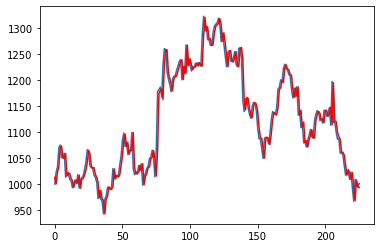

 12%|█▏        | 243/2000 [01:53<13:38,  2.15it/s]

predicted=3165.102758, expected=3100.000000
predicted=3091.338608, expected=3155.000000
predicted=3160.378507, expected=3145.000000
predicted=3149.057623, expected=3155.000000
predicted=3154.467558, expected=3300.000000
predicted=3307.385925, expected=3355.000000
predicted=3356.053913, expected=3555.000000
predicted=3562.185982, expected=3600.000000
predicted=3596.997925, expected=3630.000000
predicted=3630.644030, expected=3540.000000
predicted=3532.539476, expected=3515.000000
predicted=3523.106256, expected=3455.000000
predicted=3457.213955, expected=3425.000000
predicted=3426.403397, expected=3390.000000
predicted=3387.018576, expected=3515.000000
predicted=3526.779292, expected=3635.000000
predicted=3642.464471, expected=3680.000000
predicted=3673.459688, expected=3580.000000
predicted=3561.335314, expected=3420.000000
predicted=3408.704866, expected=3535.000000
predicted=3561.593614, expected=3630.000000
predicted=3647.280347, expected=3560.000000
predicted=3538.409529, expected=

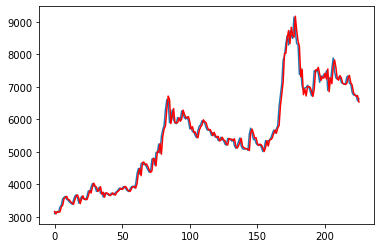

 13%|█▎        | 255/2000 [03:15<25:45,  1.13it/s]

predicted=997.579583, expected=985.000000
predicted=986.045368, expected=979.000000
predicted=979.923073, expected=982.000000
predicted=983.434105, expected=994.000000
predicted=992.681709, expected=1001.000000
predicted=999.956047, expected=1020.000000
predicted=1019.070111, expected=1015.000000
predicted=1014.692789, expected=1013.000000
predicted=1013.017864, expected=993.000000
predicted=993.374678, expected=983.000000
predicted=984.552727, expected=970.000000
predicted=970.471687, expected=955.000000
predicted=955.495656, expected=948.000000
predicted=947.192748, expected=942.000000
predicted=942.026026, expected=963.000000
predicted=962.732162, expected=948.000000
predicted=947.209432, expected=959.000000
predicted=957.737359, expected=956.000000
predicted=955.881894, expected=952.000000
predicted=953.264167, expected=952.000000
predicted=950.875668, expected=968.000000
predicted=969.039141, expected=980.000000
predicted=979.917691, expected=980.000000
predicted=979.058440, expec

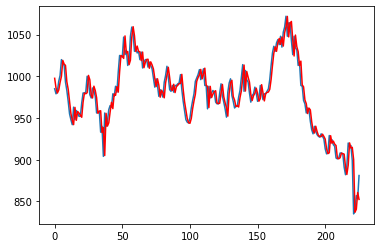

 18%|█▊        | 360/2000 [04:49<24:24,  1.12it/s]

predicted=7357.465673, expected=7296.000000
predicted=7288.855203, expected=7244.000000
predicted=7246.105271, expected=7255.000000
predicted=7260.322420, expected=7274.000000
predicted=7275.284936, expected=7357.000000
predicted=7362.702025, expected=7606.000000
predicted=7623.094733, expected=7604.000000
predicted=7586.570613, expected=7598.000000
predicted=7594.022061, expected=7789.000000
predicted=7808.677684, expected=7680.000000
predicted=7657.862627, expected=7665.000000
predicted=7667.610499, expected=7560.000000
predicted=7554.601906, expected=7726.000000
predicted=7746.906249, expected=7633.000000
predicted=7615.892139, expected=7850.000000
predicted=7871.338031, expected=7801.000000
predicted=7786.375823, expected=7870.000000
predicted=7874.075296, expected=7709.000000
predicted=7693.782969, expected=7643.000000
predicted=7644.842411, expected=7793.000000
predicted=7813.979554, expected=7704.000000
predicted=7686.601820, expected=7635.000000
predicted=7631.455013, expected=

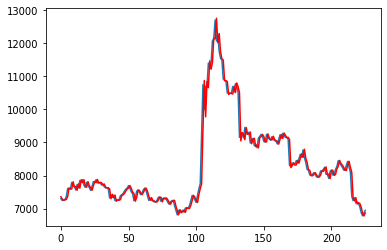

 34%|███▎      | 670/2000 [05:56<09:55,  2.23it/s]

predicted=3100.082512, expected=3097.000000
predicted=3089.303931, expected=3061.000000
predicted=3062.656079, expected=3097.000000
predicted=3099.638373, expected=3094.000000
predicted=3081.759200, expected=3127.000000
predicted=3126.785063, expected=3137.000000
predicted=3135.939559, expected=3106.000000
predicted=3107.680675, expected=3114.000000
predicted=3114.022640, expected=3075.000000
predicted=3076.334690, expected=3096.000000
predicted=3096.302409, expected=3080.000000
predicted=3077.518331, expected=3107.000000
predicted=3107.680748, expected=3095.000000
predicted=3092.434872, expected=3055.000000
predicted=3054.481492, expected=3108.000000
predicted=3108.413816, expected=3201.000000
predicted=3207.891515, expected=3223.000000
predicted=3224.041137, expected=3080.000000
predicted=3071.788057, expected=3125.000000
predicted=3130.905180, expected=3159.000000
predicted=3169.073655, expected=3144.000000
predicted=3142.229715, expected=3144.000000
predicted=3133.618898, expected=

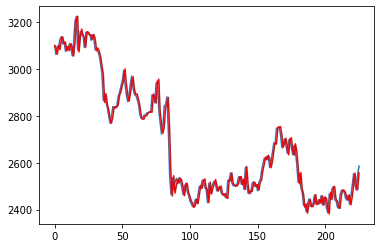

 34%|███▎      | 673/2000 [07:00<14:03,  1.57it/s]

predicted=3921.402509, expected=3900.000000
predicted=3885.019329, expected=3860.000000
predicted=3863.858991, expected=3880.000000
predicted=3890.493331, expected=3870.000000
predicted=3870.338789, expected=3945.000000
predicted=3946.083757, expected=4005.000000
predicted=4008.428360, expected=3985.000000
predicted=3979.733406, expected=3990.000000
predicted=3981.620226, expected=3980.000000
predicted=3983.627741, expected=3945.000000
predicted=3945.951476, expected=3880.000000
predicted=3875.879496, expected=3895.000000
predicted=3897.771254, expected=3960.000000
predicted=3970.094704, expected=3880.000000
predicted=3876.568409, expected=3905.000000
predicted=3894.542659, expected=3945.000000
predicted=3954.005530, expected=4015.000000
predicted=4021.823610, expected=3970.000000
predicted=3961.729297, expected=3925.000000
predicted=3915.339392, expected=3970.000000
predicted=3975.406453, expected=3950.000000
predicted=3958.670315, expected=3955.000000
predicted=3949.527775, expected=

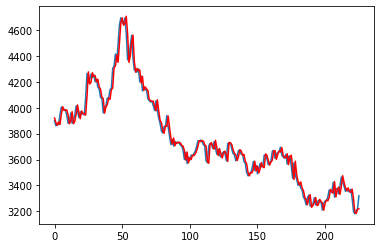

 34%|███▍      | 675/2000 [08:04<19:58,  1.11it/s]

predicted=447.517158, expected=445.000000
predicted=444.773772, expected=442.000000
predicted=441.990285, expected=448.000000
predicted=448.261196, expected=448.000000
predicted=447.967137, expected=455.000000
predicted=455.201772, expected=453.000000
predicted=453.028144, expected=458.000000
predicted=458.179526, expected=462.000000
predicted=462.476904, expected=451.000000
predicted=450.235516, expected=452.000000
predicted=452.037100, expected=451.000000
predicted=451.314312, expected=452.000000
predicted=451.802324, expected=453.000000
predicted=453.034174, expected=450.000000
predicted=449.783289, expected=452.000000
predicted=452.104440, expected=458.000000
predicted=458.467822, expected=463.000000
predicted=463.218050, expected=462.000000
predicted=461.850624, expected=450.000000
predicted=449.309509, expected=450.000000
predicted=450.143908, expected=456.000000
predicted=456.648210, expected=459.000000
predicted=458.908981, expected=456.000000
predicted=455.600039, expected=467

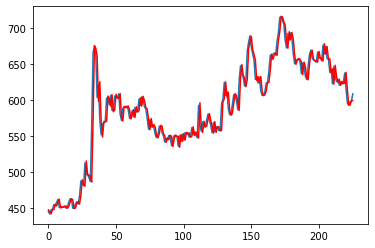

 47%|████▋     | 935/2000 [09:45<10:25,  1.70it/s]

predicted=470.198275, expected=462.000000
predicted=461.503279, expected=464.000000
predicted=464.468637, expected=476.000000
predicted=477.827570, expected=484.000000
predicted=484.589114, expected=494.000000
predicted=494.122618, expected=505.000000
predicted=504.967403, expected=504.000000
predicted=503.301586, expected=497.000000
predicted=495.888101, expected=496.000000
predicted=495.687003, expected=490.000000
predicted=489.896785, expected=485.000000
predicted=485.046292, expected=493.000000
predicted=493.782878, expected=491.000000
predicted=491.095705, expected=485.000000
predicted=484.561682, expected=483.000000
predicted=482.591660, expected=486.000000
predicted=486.564178, expected=498.000000
predicted=499.127999, expected=498.000000
predicted=497.757913, expected=480.000000
predicted=478.231553, expected=482.000000
predicted=481.960163, expected=489.000000
predicted=490.036404, expected=494.000000
predicted=494.984521, expected=504.000000
predicted=504.198899, expected=513

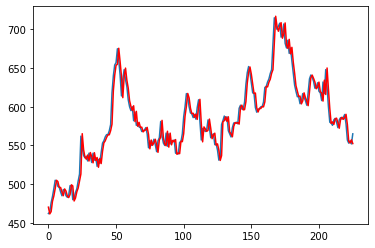

 47%|████▋     | 939/2000 [11:23<15:59,  1.11it/s]

predicted=2469.558377, expected=2426.000000
predicted=2421.421651, expected=2391.000000
predicted=2387.172488, expected=2412.000000
predicted=2421.717693, expected=2430.000000
predicted=2433.470818, expected=2422.000000
predicted=2420.999297, expected=2434.000000
predicted=2431.115330, expected=2462.000000
predicted=2462.983277, expected=2500.000000
predicted=2502.594212, expected=2489.000000
predicted=2484.993629, expected=2464.000000
predicted=2460.104133, expected=2472.000000
predicted=2471.795394, expected=2466.000000
predicted=2468.709515, expected=2453.000000
predicted=2453.753240, expected=2420.000000
predicted=2416.755831, expected=2451.000000
predicted=2455.170961, expected=2471.000000
predicted=2472.807546, expected=2472.000000
predicted=2472.665720, expected=2486.000000
predicted=2482.228281, expected=2453.000000
predicted=2450.313929, expected=2472.000000
predicted=2474.736549, expected=2508.000000
predicted=2509.269692, expected=2550.000000
predicted=2554.215342, expected=

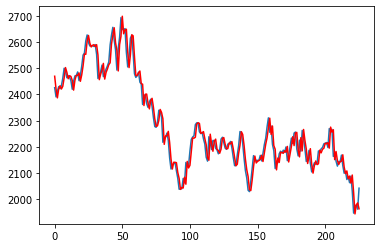

 88%|████████▊ | 1768/2000 [12:24<00:56,  4.12it/s]

predicted=4946.629403, expected=4905.000000
predicted=4900.870049, expected=4810.000000
predicted=4815.461683, expected=4830.000000
predicted=4843.134710, expected=4865.000000
predicted=4865.929049, expected=4905.000000
predicted=4902.583614, expected=4915.000000
predicted=4902.514682, expected=4930.000000
predicted=4929.196203, expected=5020.000000
predicted=5021.808669, expected=5030.000000
predicted=5035.225895, expected=4990.000000
predicted=4986.665192, expected=5050.000000
predicted=5047.261471, expected=4965.000000
predicted=4978.912622, expected=4990.000000
predicted=4987.394140, expected=4925.000000
predicted=4924.253383, expected=4935.000000
predicted=4941.506100, expected=4845.000000
predicted=4839.524623, expected=4815.000000
predicted=4817.309398, expected=4820.000000
predicted=4816.279112, expected=4765.000000
predicted=4770.905963, expected=4735.000000
predicted=4724.458345, expected=4815.000000
predicted=4812.643638, expected=4945.000000
predicted=4949.199615, expected=

 88%|████████▊ | 1768/2000 [12:40<00:56,  4.12it/s]

predicted=4879.829397, expected=4750.000000
predicted=4719.655419, expected=4600.000000
predicted=4585.328464, expected=4535.000000
predicted=4550.523804, expected=4565.000000
predicted=4582.438133, expected=4540.000000
predicted=4533.845848, expected=4470.000000
predicted=4451.989794, expected=4440.000000
predicted=4431.954582, expected=4340.000000
predicted=4344.581087, expected=4380.000000
predicted=4378.789116, expected=4345.000000
predicted=4344.059391, expected=4250.000000
predicted=4243.435733, expected=4190.000000
predicted=4176.801148, expected=4195.000000
predicted=4203.691184, expected=4165.000000
predicted=4165.362617, expected=4020.000000
predicted=4005.944365, expected=3890.000000
predicted=3877.458854, expected=3795.000000
predicted=3796.620304, expected=3855.000000
predicted=3859.312434, expected=3920.000000
predicted=3914.136058, expected=3995.000000
predicted=3982.898546, expected=3975.000000
predicted=3961.325723, expected=3935.000000
predicted=3934.477723, expected=

 89%|████████▉ | 1788/2000 [12:50<01:31,  2.32it/s]


KeyboardInterrupt: ignored

In [45]:
rmse_over_avg_price = []
for stock, X in tqdm(merged_df.groupby("SecuritiesCode")):
  # print(series[1])
  # print(type(stock))
  if int(stock) not in random_stocks:
    continue
  train, test = X[X["Date"]<=splitting_date]["close_adj"].values, X[X["Date"]>splitting_date]["close_adj"].values
  history = [x for x in train]
  predictions = list()
  # walk-forward validation
  for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(low_memory=True)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
  # evaluate forecasts
  rmse = sqrt(mean_squared_error(test, predictions))
  rmse_over_avg_price.append(rmse/np.mean(test))
  # print('Test RMSE: %.3f' % rmse)
  # plot forecasts against actual outcomes
  plt.plot(test)
  plt.plot(predictions, color='red')
  plt.show()
print(rmse_over_avg_price)

In [ ]:
print(f"The RMSE of the prediction over 20 stocks (scaled to each price) is {np.mean(rmse_over_avg_price)}")

### 2. State-of-the-Art Time-Series Machine Learning Model Testing: Temporal Fusion Transformer 
The second model we used as a time-series model si Temporal Fusion Transformer. 

**Temporal Fusion Transformer** is a transformer-based Time-Series Forecasting model that was published in the paper 
*Temporal Fusion Transformers
for Interpretable Multi-horizon Time Series Forecasting (Lim et al., 2020)*

To learn temporal rela- tionships at different scales, TFT uses recurrent layers for local processing and interpretable self-attention layers for long-term dependencies. TFT utilizes specialized components to select relevant features and a series of gating layers to suppress unnecessary components, enabling high performance in a wide range of scenarios.

The Model architecture is as follows:

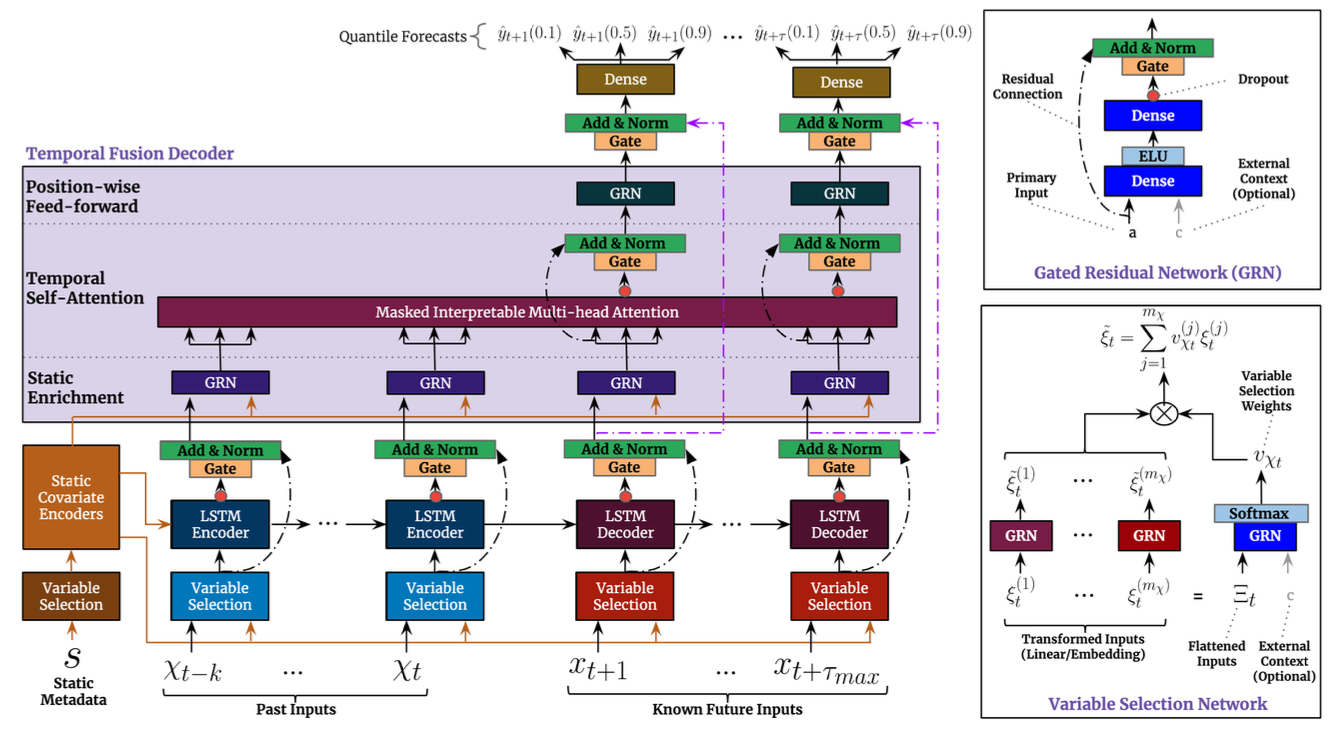

In [ ]:
!pip install pytorch-forecasting
!pip install scipy

In [ ]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder, EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

### Creating TimeSeriesDataset

In order to use the TimeSeriesDataset Class from the Pytorch Lightning library, we add num_idx column using the date column, since the TimeSeriesDataset instance requires an index column in integers. \\
 \\
We also split the train-test dataset with the ratio 8:2, so we also set the splitting date as 2020-12-31 and find the corresponding index. 


In [ ]:
# convert data to num_idx and add as a column in the dataframe
list_of_dates = set(merged_df["Date"].apply(lambda x: int(x.timestamp())//(10**2)))
date_to_idx_dict = dict(zip(sorted(list_of_dates), range(len(list_of_dates))))
merged_df["num_idx"] = merged_df["Date"].apply(lambda x: date_to_idx_dict[int(x.timestamp())//(10**2)])

# Security Names, and their industry code does contain some useful information in predicting the future prices
merged_df["SecuritiesCode"] = merged_df["SecuritiesCode"].astype(str)
merged_df["33SectorCode"] = merged_df["33SectorCode"].astype(str)

# Split Train-Test dataset using the spliiting_date
splitting_date = "2020-12-31"
train_df, test_df = merged_df[merged_df['Date'] <= splitting_date], merged_df[merged_df['Date'] > splitting_date]

### Finding the optimal learning rate
Using Trainer.tuner.lr_find module from pytorch forecasting, we find the Learning Rate that is optimal for this dataset. This function checks the model performance across several learning rate candidates and suggests the best one. \\
We found the optimal learning rate to be 0.03

In [ ]:
# This code take 20min+ to run, so we only include the results from the run

# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloaders = train_dataloader,
#     val_dataloaders = val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )
# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()
PATIENCE = 30
MAX_EPOCHS = 120
LEARNING_RATE = 0.03
OPTUNA = False
DEVICE = "cuda"

### Defining the TFT model training function
We now define a function that trains Temporal Fusion Transformer and outputs the trained trainer instance.

In [ ]:
len(train_df.columns)

In [ ]:
def tft_train_enc_pred(max_encoder_length = 5, max_prediction_length = 2):
  training = TimeSeriesDataSet(
      train_df,
      group_ids=["SecuritiesCode"],
      target="close_adj",
      time_idx="num_idx",
      min_encoder_length=max_encoder_length,
      max_encoder_length=max_encoder_length,
      min_prediction_length=1,
      max_prediction_length=max_prediction_length,
      time_varying_known_reals=["num_idx", 'volume'],
      time_varying_unknown_reals=['open_adj', 'high_adj', 'low_adj',
                                  'close_adj' ],
      static_categoricals = ['SecuritiesCode','33SectorCode'],
      allow_missing_timesteps=True,
      categorical_encoders = {
      },
      add_target_scales=True,
  )
  validation = TimeSeriesDataSet.from_dataset(training, test_df, predict=True, stop_randomization=True)

  # create dataloaders for model
  batch_size = 128 
  train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
  val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

  # configure network and trainer
  early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
  lr_logger = LearningRateMonitor() 
  logger = TensorBoardLogger("lightning_logs")

  trainer = pl.Trainer(
      max_epochs=30,
      gpus=0,
      enable_model_summary=True,
      gradient_clip_val=0.1,
      limit_train_batches=30,  
      callbacks=[lr_logger, early_stop_callback],
      logger=logger,
  )

  tft = TemporalFusionTransformer.from_dataset(
      training,
      learning_rate=0.03,
      hidden_size=16,
      attention_head_size=1,
      dropout=0.1,
      hidden_continuous_size=8,
      output_size=7, # dimension of 7 for QuantileLoss
      loss=QuantileLoss(),
      log_interval=10,
      reduce_on_plateau_patience=4,
  )

  tft.to(DEVICE)
  print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

  trainer.fit(
      tft,
      train_dataloaders = train_dataloader,
      val_dataloaders=val_dataloader,
  )
  return trainer, train_dataloader, val_dataloader

#### TFT model that predicts the prices into the future (t, t+1) with the information from last 5 time data

Note that from the output plots, this model actually uses Quantile Regression (quantile of 10%, 25%, 50%, 75%, 90%) to make more "informed" prediction about the stock prices (shown in orange bands) The actual prediction is represented as orange lines. Moreover, the gray lines indicate the attention the model imposed over the time-series data to predict the next data point. These interpretations are possible because we are now using Transformers, which is an attention model.

In [ ]:
# 5-2
trainer5_2, train_dataloader5_2, val_dataloader5_2 = tft_train_enc_pred(5,2)
best_model_path = trainer5_2.checkpoint_callback.best_model_path
best_tft5_2 = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader5_2)])
predictions5_2 = best_tft5_2.predict(val_dataloader5_2, mode="prediction")
raw_predictions5_2, x5_2 = best_tft5_2.predict(val_dataloader5_2, mode="raw", return_x=True)

print(raw_predictions5_2.prediction.shape[0])
for idx in range(raw_predictions5_2.prediction.shape[0]):
    best_tft5_2.plot_prediction(x5_2, raw_predictions5_2, idx=idx, add_loss_to_title=False);
    if idx ==5:
      break

In [ ]:
loss = nn.MSELoss()
rmse = torch.sqrt(loss(raw_predictions5_2.prediction[:,0,3], x5_2["decoder_target"][:,0]))/x5_2["decoder_target"][:,0]
rmse_over_avg_price = torch.mean(rmse)
print(f"The RMSE of the prediction over 20 stocks (scaled to each price) is {rmse_over_avg_price}")

We can see that the attention model is doing poorly in performance measured in RMSE, because it is (on average) giving us predictions that are 39% off from the real target price!

As a bonus, we also conducted a model that recieves 22 data points and predicts the next 5 time points in the data.

### TFT model that predicts the prices into the future (t, t+1, t+2, t+3, t+4) with the information from last 22 time data (1 month)

In [ ]:
trainer22_5, train_dataloader, val_dataloader22_5 = tft_train_enc_pred(22,5)
best_model_path = trainer22_5.checkpoint_callback.best_model_path
best_tft22_5 = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader22_5)])
predictions = best_tft22_5.predict(val_dataloader22_5, mode="prediction")
raw_predictions22_5, x = best_tft22_5.predict(val_dataloader22_5, mode="raw", return_x=True)

print(raw_predictions22_5.prediction.shape[0])
for idx in range(raw_predictions22_5.prediction.shape[0]):
    best_tft22_5.plot_prediction(x, raw_predictions22_5, idx=idx, add_loss_to_title=False);
    if idx ==10:
      break

In [ ]:
loss = nn.MSELoss()
rmse = torch.sqrt(loss(raw_predictions22_5.prediction[:,0,3], x["decoder_target"][:,0]))/x["decoder_target"][:,0]
rmse_over_avg_price = torch.mean(rmse)
print(f"The RMSE of the prediction over 20 stocks (scaled to each price) is {rmse_over_avg_price}")

We can see that the model that uses more data point does perform well than the previous one, but it is still short of the ARIMA model. (What a shame!)

**With these baseline performance in mind, we move over to using features that we can construct using the Technical Analysis Library!**

## Naive Check for the Feature Correlation

For the features selection process, first, we collected all the 69 TA-Lib quantitative indicators except for those with pattern recognition (as pattern recognition indicators are already based on other indicators) and used the open, low, high, and close prices of the Nikkei index as the inputs for the indicators based on the fact that Nikkei index represents the overall Japanese stock market. We used this top-down approach to check the correlations by printing the heatmap between the quantitative indicators.

Total 69 TA-Lib quantitative indicators are from the categories of Overlap Studies, Momentum Indicators, Volume Indicators, Volatility Indicators, Cycle Indicators, Price Transform, and Statistics Functions, and we found that five indicators, HT_DCPERIOD, HT_PHASOR_1, HT_TRENDMODE, BETA, CORREL, have low correlations with each other (in the correlation matrix, the rows and columns are 83 each as some indicators have more than one output). In addition to these, we also added close price (adjusted for both stock split and reverse stock split), trading volume, and sector (industry) code as features. For the purpose of post-verification, we printed the heatmaps for 20 randomly sampled individual stocks to check that the low correlations not only hold for the market index but also hold for individual stocks.

### Total 69 TA-Lib quantitative indicators:

In [46]:
# Indicators to add.
overlap_indicator = {
  "BBANDS": {
    "columns": ["close"],
    "kwargs": {"timeperiod":5, "nbdevup":2.0, "nbdevdn":2.0, "matype":0},
    "explanation": "Bollinger Bands - "
  },
  "DEMA": {
    "columns": ["close"],
    "kwargs": {"timeperiod":30},
    "explanation": "Double Exponential Moving Average - "
  },
  "EMA": {
    "columns": ["close"],
    "kwargs": {"timeperiod":30},
    "explanation": "Exponential Moving Average - "
  },
  "HT_TRENDLINE": {
    "columns": ["close"],
    "kwargs": {},
    "explanation": "Hilbert Transform - Instantaneous Trendline - "
  },
  "KAMA": {
    "columns": ["close"],
    "kwargs": {"timeperiod":30},
    "explanation": "Kaufman Adaptive Moving Average - "
  },
  "MA": {
    "columns": ["close"],
    "kwargs": {"matype":0, "timeperiod":30},
    "explanation": "Moving average - "
  },
  "MIDPOINT": {
    "columns": ["close"],
    "kwargs": {"timeperiod":14},
    "explanation": "MidPoint over period - "
  },
  "MIDPRICE": {
    "columns": ["high", "low"],
    "kwargs": {"timeperiod":14},
    "explanation": "Midpoint Price over period - "
  },
  "SAR": {
    "columns": ["high", "low"],
    "kwargs": {"acceleration":0.0, "maximum":0.0},
    "explanation": "Parabolic SAR - "
  },
  "SAREXT": {
    "columns": ["high", "low"],
    "kwargs": {"startvalue":0.0, "offsetonreverse":0.0, "accelerationinitlong":0.0, "accelerationlong":0.0, "accelerationmaxlong":0.0, "accelerationinitshort":0.0,
               "accelerationshort":0.0, "accelerationmaxshort":0.0},
    "explanation": "Parabolic SAR - Extended - "
  },
  "SMA": {
    "columns": ["close"],
    "kwargs": {"timeperiod":30},
    "explanation": "Simple Moving Average - "
  },
  "T3": {
    "columns": ["close"],
    "kwargs": {"timeperiod":5, "vfactor":0.0},
    "explanation": "Triple Exponential Moving Average (T3) - "
  },
  "TEMA": {
    "columns": ["close"],
    "kwargs": {"timeperiod":30},
    "explanation": "Triple Exponential Moving Average - "
  },
  "TRIMA": {
    "columns": ["close"],
    "kwargs": {"timeperiod":30},
    "explanation": "Triangular Moving Average - "
  },
  "WMA": {
    "columns": ["close"],
    "kwargs": {"timeperiod":30},
    "explanation": "Weighted Moving Average - "
  },
}

volume_indicator = {
  "AD":{
    "columns":["high", "low", "close", "volume"],
    "kwargs":{},
    "explanation": "Chaikin A/D Line - "
  },
  "ADOSC":{"columns":["high", "low", "close", "volume"],
    "kwargs":{"fastperiod":3, "slowperiod":10},
    "explanation": "Chaikin A/D Oscillator - "
  },
  "OBV":{
    "columns":["close", "volume"],
    "kwargs":{},
    "explanation": "On Balance Volume - "
  }
}

volatility_indicator = {
  "ATR":{
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Average True Range - "
  },
  "NATR":{
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Normalized Average True Range - "
  },
  "TRANGE":{
    "columns":["high", "low", "close"],
    "kwargs":{},
    "explanation": "True Range - "
  },
}

price_transform_indicator = {
  "AVGPRICE":{
    "columns":["open","high", "low", "close"],
    "kwargs":{},
    "explanation": "Average True Range - "
  },
  "MEDPRICE":{
    "columns":["high", "low"],
    "kwargs":{},
    "explanation": "Normalized Average True Range - "
  },
  "TYPPRICE":{
    "columns":["high", "low", "close"],
    "kwargs":{},
    "explanation": "True Range - "
  },
  "WCLPRICE":{
    "columns":["high", "low", "close"],
    "kwargs":{},
    "explanation": "True Range - "
  },
}

cycle_indicator = {
  "HT_DCPERIOD":{
    "columns":["close"],
    "kwargs":{},
    "explanation": "Hilbert Transform - Dominant Cycle Period - "
  },
  "HT_DCPHASE":{
    "columns":["close"],
    "kwargs":{},
    "explanation": " - "
  },
  "HT_PHASOR":{
    "columns":["close"],
    "kwargs":{},
    "explanation": " - "
  },
  "HT_SINE":{
    "columns":["close"],
    "kwargs":{},
    "explanation": " - "
  },
  "HT_TRENDMODE":{
    "columns":["close"],
    "kwargs":{},
    "explanation": " - "
  },
}

momentum_indicator = {
  "ADX": {
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Average Directional Movement Index - "
  },
  "ADXR":{
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Average Directional Movement Index Rating - "
  },  
  "APO":{
    "columns":["close"],
    "kwargs":{"fastperiod":12, "slowperiod":26, "matype":0},
    "explanation": "Absolute Price Oscillator - "
  },         
  "AROON":{
    "columns":["high", "low"],
    "kwargs":{"timeperiod":14},
    "explanation": "Aroon - "
  },           
  "AROONOSC":{
    "columns":["high", "low"],
    "kwargs":{"timeperiod":14},
    "explanation": "Aroon Oscillator - "
  },       
  "BOP":{
    "columns":["open", "high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Balance Of Power - "
  },   
  "CCI":{
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Commodity Channel Index - "
  },
  "CMO":{
    "columns":["close"],
     "kwargs":{"timeperiod":14},
     "explanation": "Chande Momentum Oscillator - "
  },
  "DX":{
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Directional Movement Index - "
  },
  "MACD":{
    "columns":["close"],
    "kwargs":{"fastperiod":12, "slowperiod":26, "signalperiod":9},
    "explanation": "Moving Average Convergence/Divergence - " 
  },
  "MACDEXT":{
    "columns":["close"],
    "kwargs":{"fastperiod":12, "fastmatype":0, "slowperiod":26, "slowmatype":0, "signalperiod":9, "signalmatype":0},
    "explanation": "MACD with controllable MA type - "  
  },
  "MACDFIX":{
    "columns":["close"],
    "kwargs":{"signalperiod":9},
    "explanation": "Moving Average Convergence/Divergence Fix 12/26 - " 
  },      
  "MFI":{
    "columns":["high", "low", "close", "volume"],
    "kwargs":{"timeperiod":14},
    "explanation": "Money Flow Index - "
  },
  "MINUS_DI":{
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Minus Directional Indicator - "
  },  
  "MINUS_DM":{
    "columns":["high", "low"],
    "kwargs":{"timeperiod":14},
    "explanation": "Minus Directional Movement - "
  },
  "MOM":{
    "columns":["close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Momentum - "
  },
  "PLUS_DI":{
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Plus Directional Indicator - "
  },    
  "PLUS_DM":{
    "columns":["high", "low"],
    "kwargs":{"timeperiod":14},
    "explanation": "Plus Directional Movement - "
  },      
  "PPO":{
    "columns":["close"],
    "kwargs":{"fastperiod":12, "slowperiod":26, "matype":0},
    "explanation": "Percentage Price Oscillator - "
  },
  "ROC":{
    "columns":["close"],
    "kwargs":{"timeperiod":10},
    "explanation": "Rate of change : ((price/prevPrice)-1)*100 - "
  },
  "ROCP":{
    "columns":["close"],
    "kwargs":{"timeperiod":10},
    "explanation": "Rate of change Percentage: (price-prevPrice)/prevPrice - "
  },
  "ROCR":{
    "columns":["close"],
    "kwargs":{"timeperiod":10},
    "explanation": "Rate of change ratio: (price/prevPrice) - "
  },
  "ROCR100":{
    "columns":["close"],
    "kwargs":{"timeperiod":10},
    "explanation": "Rate of change ratio 100 scale: (price/prevPrice)*100 - "
  },
  "RSI":{
    "columns":["close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Relative Strength Index - "
  },
  "STOCH":{
    "columns":["high", "low", "close"],
    "kwargs":{"fastk_period":5, "slowk_period":3, "slowk_matype":0, "slowd_period":3, "slowd_matype":0},
    "explanation": "Stochastic - "
  },
  "STOCHF":{
    "columns":["high", "low", "close"],
    "kwargs":{"fastk_period":5, "fastd_period":3, "fastd_matype":0},
    "explanation": "Stochastic Fast - "
  },
  "STOCHRSI":{
    "columns":["close"],
    "kwargs":{"timeperiod":14, "fastk_period":5, "fastd_period":3, "fastd_matype":0},
    "explanation": "Stochastic Relative Strength Index - "
  },       
  "TRIX":{
    "columns":["close"],
    "kwargs":{"timeperiod":30},
    "explanation": "1-day Rate-Of-Change (ROC) of a Triple Smooth EMA - "
  },
  "ULTOSC":{
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod1":7, "timeperiod2":14, "timeperiod3":28},
    "explanation": "Ultimate Oscillator - "
  },  
  "WILLR":{
    "columns":["high", "low", "close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Williams' %R - "
  }
}

statistic_functions = {
  "BETA":{
    "columns":["high", "low"],
    "kwargs":{"timeperiod":5},
    "explanation": "Beta - "
  },
  "CORREL":{
    "columns":["high", "low"],
    "kwargs":{"timeperiod":30},
    "explanation": "Pearson's Correlation Coefficient (r) - "
  },
  "LINEARREG":{
    "columns":["close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Linear Regression - "
  },
  "LINEARREG_ANGLE":{
    "columns":["close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Linear Regression Angle - "
  },
  "LINEARREG_INTERCEPT":{
    "columns":["close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Linear Regression Intercept - "
  },
  "LINEARREG_SLOPE":{
    "columns":["close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Linear Regression Slope - "
  },
  "STDDEV":{
    "columns":["close"],
    "kwargs":{"timeperiod":5, "nbdev":1.0},
    "explanation": "Standard Deviation - "
  },
  "TSF":{
    "columns":["close"],
    "kwargs":{"timeperiod":14},
    "explanation": "Time Series Forecast - "
  },
  "VAR":{
    "columns":["close"],
    "kwargs":{"timeperiod":5, "nbdev":1.0},
    "explanation": "Variance - "
  }
}

We added all of the indicators above to `nikkei_df` using the TA-Lib apis. After these, `nikkei_df` contained additional 69 columns each of which corresponds to the indicator value on a day. 

In [47]:
# Setting date into index.
nikkei_df.set_index('Date', inplace=True)

In [48]:
# The functions to calculate and attach indicators to the target dataframe.

# Adding TA-Lib indicator values.
def add_talib_col(df, ta_fn, columns, **kwargs):
  # drop nans
  df.dropna(subset=columns, inplace=True)

  cols = [] # output column names 
  data_nps = dict(zip(columns, [df[col] for col in columns]))
  res = ta_fn(*data_nps.values(), **kwargs)

  # Checks if the output has multiple values
  if len(res) != len(df):
    for i in range(len(res)):
      col_name = f"{ta_fn._Function__namestr}_{i}"
      df[col_name] = res[i]
      cols.append(col_name)
  else:
    df[f"{ta_fn._Function__namestr}"] = res
    cols.append(f"{ta_fn._Function__namestr}")

  return df, cols

# Adding multiple TA-Lib indicator values.
def add_indicators(df, indicators):
  columns_to_plot = []
  for ind in indicators:
    df, cols = add_talib_col(df, globals()[ind], indicators[ind]["columns"], **indicators[ind]["kwargs"])
    columns_to_plot += cols

  return df, columns_to_plot

In [49]:
# Adding all indicators in nikkei_df dataframe.
indicators = {}
indicators.update(overlap_indicator)
indicators.update(volume_indicator)
indicators.update(volatility_indicator)
indicators.update(price_transform_indicator)
indicators.update(cycle_indicator)
indicators.update(momentum_indicator)
indicators.update(statistic_functions)

nikkei_df, added_cols = add_indicators(nikkei_df, indicators)

### The correlation heatmap between the indicators

Text(0.5, 1.0, 'The correlations between all indicators in Nikkei dataframe')

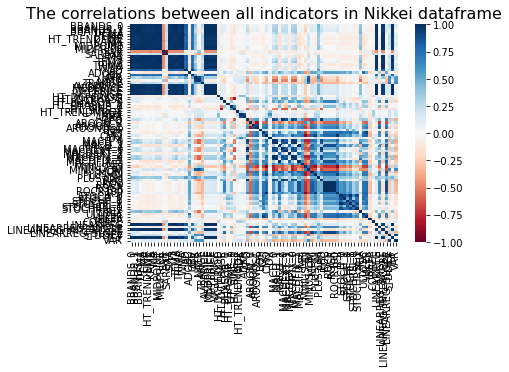

In [58]:
# Plotting the correlation between the indicators.
corr = nikkei_df[added_cols].corr()

ax = sns.heatmap(
    data = corr,
    vmin=-1,
    vmax=1,
    cmap='RdBu',
    xticklabels=True, 
    yticklabels=True,
)
ax.set_title(f"The correlations between all indicators in Nikkei dataframe", fontdict= {'fontsize': 16})

As we can see from the heatmap, there are a lot of correlated indicators especially in the same category. Obviously we cannot use all of these, since this will bring the multicollinearity and makes our model too complicated.

Here, we filtered out the indicators which have the correlation values below the threshold 0.5 with all other indicators. While this is simple way, we assumed that this would give us the indicators that are surely not correlated to others in certain extent.

In [ ]:
# Getting the candidates whose corrleation to others are lower than the threshold
corr_threshold = 0.5
candidates = []
for r, row in tqdm(corr.iterrows()):
  max_abs_cor = 0.0
  for idx, item in row.items():
    if idx != r:
      max_abs_cor = max(max_abs_cor, abs(item))
  
  if max_abs_cor < corr_threshold:
    candidates.append(r)

In [ ]:
candidates

##Defining the Stock Class Representing for a Single Stock

Additionally, we designed a separate Stock class to contain the dataframe only for a certain stock and various functions to use it. We didn't filter out the dataframe for each stock manually whenever we need it, but made a separate object for each stock beforehand, so that we can use each stock information more conveniently. \\
Let us describe what each property and method is: \\
- `self.security_code`: The security code of the stock.
- `self.name`: The name of the company.
- `self.sector_code`: The industry code of the stock.
- `self.industy`: The industry category of the stock.
- `self.df`: The dataframe of the stock. Note that the columns are the same as those of `merged_df`.

- `self.update_indicators`: The function which gets the indicator arguments as input, calls the TA-Lib's library to calculate requested indicators, update `self.df` internally, and finally return the name of the added columns.
- `self.plot_indicators`: The function which makes a line plot of calculated indicators before hands. If `return_data=False`, it just produce and show the lineplot fot this single stock. If `return_data=True`, it does not make a plot, but just return the data for plotting so that an outer function/object can aggregate it and make a plot for multiple stocks.
- `self.plot_close_price`: The function which make a line plot of the adjusted close price throughout the entire time range. If `return_data=True`, it does not make a plot, but just return the dataframe so that an outer function/object can aggregate it and make a plot for multiple stocks.
- `self.plot_corr`: The function which make a heatmap of the correlation between the columns which are given as an input. If `return_data=True`, it does not make a plot, but just return the correlation matrix.

In [ ]:
class Stock:
  def __init__(self, security_code, merged_df):
    self.security_code = security_code
    self.name = merged_df[merged_df['SecuritiesCode'] == self.security_code]['Name'].iloc[0]
    self.sector_code = merged_df[merged_df['SecuritiesCode'] == self.security_code]['33SectorCode'].iloc[0]
    self.industry = merged_df[merged_df['SecuritiesCode'] == self.security_code]['33SectorName'].iloc[0]
    
    self.df = merged_df[merged_df['SecuritiesCode'] == self.security_code].sort_values('Date')
    self.df.set_index('Date', inplace=True)

  # Adding TA-Lib indicators into the stock dataframe.
  def update_indicators(self, indicators):
    res_df, res_cols = add_indicators(self.df, indicators)
    self.df = res_df
    return res_cols

  # Plotting the indicators added.
  def plot_indicators(self, cols=[], return_data=False):
    data = self.df[cols].copy()
    # Min-Max normalization.
    for col in cols:
      M, m = data[col].max(), data[col].min()
      data.loc[:, col] = (data[col] - m) / (M - m)
    # If the data will be used for plotting a subplot outside.
    if return_data:
      return data

    fig = plt.figure()
    ax = sns.lineplot(data=data,  ci=95)
    ax.set_ylabel("Indicators")
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1,interval=3))

    # specify the format of the labels as 'year-month-day'
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

    # (optional) rotate the labels in order to improve their spacing
    plt.setp(ax.xaxis.get_majorticklabels(), rotation = 60, ha='right')
    ax.set_title(f"The change of TA-Lib indicators of {self.name}")
    plt.legend(bbox_to_anchor=(1.24, 1.0))

  # Plotting the close price.
  def plot_close_price(self, return_data=False):
    data = self.df[['Name', 'close_adj', 'close_norm']].copy()  # Name and norm_price are for later use.
    if return_data:
      return data

    fig = plt.figure()
    ax = sns.lineplot(data=data['close_adj'])
    ax.set_ylabel("Close price")
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1,interval=2))
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

    plt.setp(ax.xaxis.get_majorticklabels(), rotation = 60, ha='right')
    ax.set_title(f"The change of close price of {self.name}")
  
  # Plotting the correlation between the features.
  def plot_corr(self, columns=[], return_data=False):
    corr = self.df[columns].corr().round(4)
    if return_data:
      return corr

    fig = plt.figure()
    ax = sns.heatmap(
        data = corr,
        vmin=-1,
        vmax=1,
        cmap='RdBu',
        xticklabels=True, 
        yticklabels=True,
        annot=True,
        fmt='.4f',
    )
    ax.set_title(f"The correlations between features in {self.name}")

##Defining the Industry Class Representing for a Single Industry (multiple stocks)

We also made Industry class which contains the instantiated Stock objects in a certain industry category. So an Industry object just has a data strucuture to store Stock objects and the functions to call/combine/aggregate/plot them. \\

- `self.sector_code`: The industry code of the stock.
- `self.industy`: The industry category of the stock.
- `self.stocks`: The dictionary whose key is a security code and value is a Stock object of the assigned code.
- `self.top_5_stocks`: The securitycodes of top5 large stocks in this industry category. Note that they are sampled based on the market caplitalization.

- `self.add_indicators`: This function calls `update_indicators` in all Stock objects in this Industry object. So it is an outer function to add indicators for given indicator arguements as an input.
- `self.plot_top_5`: The function which plots line plots of the normalized close price of top5 stocks. If `return_data=True`, it does not make plots, but just return the dataframe which is an aggreaged version of the top5 stock's dataframes.
- `self.plot_agg`: The function which plots a line plots of the aggreageted normalize close prices of top5 stocks. The aggregation here is aveage. If `return_data=True`, it does not make a plot, but just return an aggregated dataframe of the normalized close price of top 5 stocks for later use.

In [ ]:
class Industry:
  def __init__(self, sector_code, merged_df):
    self.sector_code = sector_code
    self.industry = merged_df[merged_df['33SectorCode'] == self.sector_code]['33SectorName'].iloc[0]

    # Extracting the security codes and sorting it for getting top5.
    filtered = merged_df[merged_df['33SectorCode'] == self.sector_code].groupby('SecuritiesCode').first().reset_index()
    filtered = filtered.sort_values('MarketCapitalization', ascending=False)
    security_codes = list(filtered['SecuritiesCode'])

    self.stocks = {}
    for code in security_codes:
      stock = Stock(code, merged_df)
      self.stocks[code] = stock

    self.top_5_stocks = security_codes[:5]
  
  # Adding the indicators in each stock objects.
  def add_indicators(self, indicators):
    added_cols = []
    for i, (code, stock) in enumerate(self.stocks.items()):
      cols = stock.update_indicators(indicators)
      if i == 0:
        added_cols += cols
    return added_cols

  # Plotting the top5 stocks' close prices.
  def plot_top_5(self, return_data=False):
    df = pd.DataFrame()
    for code in self.top_5_stocks:
      df = df.append(self.stocks[code].plot_close_price(return_data=True))
    df = df.reset_index()
    if return_data:
      return df

    fig = plt.figure()
    palette = sns.color_palette(cc.glasbey, n_colors=len(self.top_5_stocks))
    ax = sns.lineplot(
        data=df,
        x='Date',
        y='close_norm',
        hue='Name',
        palette=palette
    )
    ax.set_ylabel("Normalized close price")
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1,interval=2))
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation = 60, ha='right')

    ax.set_title(f"The normalized close prices of top 5 largest stocks in {self.industry}")
    plt.legend(title='Company Name', loc='upper left', bbox_to_anchor=(1.05, 1.0))

  # Plotting the aggregated normalized price.
  def plot_agg(self, return_data=False):
    df = pd.DataFrame()
    for code in self.top_5_stocks:
      df = df.append(self.stocks[code].plot_close_price(return_data=True))
    df = df.reset_index()
    agg_df = df.groupby('Date').mean()[['close_norm']]
    agg_df['33SectorName'] = self.industry
    if return_data:
      return agg_df
    
    fig = plt.figure()
    ax = sns.lineplot(
      data=agg_df,
      x='Date',
      y='close_norm'
    )
    ax.set_ylabel("Aggregated normalized close price")
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1,interval=2))
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation = 60, ha='right')

    ax.set_title(f"The aggregated normalized close prices of top 5 largest stocks in {self.industry}")

##Data Visualization for EDA

Finally, we defined the outer function to make line plots of each industry's aggragated normalized close price. Note that each aggraged normalized price is from top5 stocks of each industry, which works as the representation of the price change of a certain industry. We can see that it calls each Industry object's `plot_agg` function with `return_data=True` to collect the aggreated dataframe from them.

In [ ]:
# Drawing the line plot of the aggregation of closed prices of each industry.
def plot_aggs_per_industry(industries, return_data=False):
  df = pd.DataFrame()
  for industry in industries:
    df = df.append(industry.plot_agg(return_data=True))
  df = df.reset_index()
  if return_data:
    return df

  fig = plt.figure()
  palette = sns.color_palette(cc.glasbey, n_colors=len(industries))
  ax = sns.lineplot(
      data=df,
      x='Date',
      y='close_norm',
      hue='33SectorName',
      palette=palette
  )
  ax.set_ylabel("Aggreagated normalized close price")
  ax.set_xlabel("Date")
  ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1,interval=2))
  ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
  plt.setp(ax.xaxis.get_majorticklabels(), rotation = 60, ha='right')

  ax.set_title(f"The aggregated normalized close prices of each industry")
  plt.legend(title='Industry', bbox_to_anchor=(1.05, 1.2))

Finally, we initialized all Industry objects. We can see from the constructor of Industry class, it internally initialize `stocks` dictionary by initializing Stock objects with securitycodes which are categorized in according industry.

In [ ]:
# Initializing each industry object.
sector_codes = stock_list_df['33SectorCode'].unique()
industries = []
for code in tqdm(sector_codes):
  industry = Industry(code, merged_df)
  industries.append(industry)

In [ ]:
# Removing the dataframe which will not be used anymore.
del stock_df
del stock_list_df
del nikkei_df

In [ ]:
# Default setting for plotting.
def default_plot_setting():
  plt.rcParams['figure.figsize'] = (24, 8)
  plt.rcParams['font.family'] = "serif"
  plt.rcParams['font.size'] = "16"
  plt.rcParams.update({'figure.max_open_warning': 0})

In [ ]:
default_plot_setting()

###Checking the number of distributions per each industry

In [ ]:
x = [industry.industry for industry in industries]
y = [len(industry.stocks) for industry in industries]
palette = sns.color_palette(cc.glasbey, n_colors=len(industries))
ax = sns.barplot(x=x, y=y, palette=palette)
for g in ax.patches:
  ax.annotate(
    int(g.get_height()),
    (g.get_x() + g.get_width() / 2., g.get_height() + 4.0),
    ha = 'center', va = 'center'
  )
ax.set(title='The number of stocks in each industry', xlabel='Industry', ylabel='The number of stocks')
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 60, ha='right')
plt.show()

###Checking the distribution of top 5 companies per each industry

In [ ]:
x = [industry.industry for industry in industries]
y = [len(industry.top_5_stocks) for industry in industries]
palette = sns.color_palette(cc.glasbey, n_colors=len(industries))
plot = sns.barplot(x=x, y=y, palette=palette)
plot.set(title='The number of top 5 stocks in each industry', xlabel='Industry', ylabel='The number of stocks')
plt.setp(plot.xaxis.get_majorticklabels(), rotation = 60, ha='right')
plt.show()

###Plotting trend of the aggregated and normalized prices per each industry

In [ ]:
plot_aggs_per_industry(industries)

We can see that each industry moves differently in scale even if we normalized the close prices of each stock. From this, we assumed that the industry code can be used a feature to help machine learning model predict the price change.

###Plotting trend of the aggregated and normalized prices for top 5 firms in each industry

In [ ]:
for industry in industries:
  industry.plot_top_5()

###Codes for the indicators of quantitative trading

We filtered out 5 useful indicators which would be used as features since they have lower correlation to other ones. We added these indicators to each stock dataframe, so that these can be included in our inputs for machine learning.

In [ ]:
# Parsing the indicators which corresponds to the candidates.
candidate_indicators = {
  "HT_DCPERIOD":{
    "columns":["close_adj"],
    "kwargs":{},
    "explanation": "Hilbert Transform - Dominant Cycle Period - "
  },
  "HT_PHASOR":{
    "columns":["close_adj"],
    "kwargs":{},
    "explanation": " - "
  },
  "HT_TRENDMODE":{
    "columns":["close_adj"],
    "kwargs":{},
    "explanation": " - "
  },
  "BETA":{
    "columns":["high_adj", "low_adj"],
    "kwargs":{"timeperiod":5},
    "explanation": "Beta - "
  },
  "CORREL":{
    "columns":["high_adj", "low_adj"],
    "kwargs":{"timeperiod":30},
    "explanation": "Pearson's Correlation Coefficient (r) - "
  },
}

In [ ]:
# Adding indicators in each stock.
added_cols = []
for i, industry in enumerate(tqdm(industries)):
  cols = industry.add_indicators(candidate_indicators)
  if i == 0:
    added_cols += cols

In [ ]:
added_cols

###Plotting trend of the quantitative indicators for 20 randomly sampled firms

Since there are $2000$ individual stocks in the dataset, we could not inspect all of the stocks so we sampled $20$ random stocks to plot the patterns between each indicators to check if they can be used as features.

In [ ]:
# Fixing the random seed.
random.seed(555)

# Random sampling the 20 stocks.
random_stocks = []
for industry in random.sample(industries, 5):
  selected_codes = random.sample(list(industry.stocks), 4)
  for code in selected_codes:
    random_stocks.append(industry.stocks[code])

In [ ]:
# Plotting the indicators.
for stock in random_stocks:
  stock.plot_indicators(candidates)

We can see that all of the indicators move differently. Note that since the scale of each indicator is varying, we implemented min-max scaling so that we can inspect only trend of each indicator's movement.

###Plotting correlation heatmap of the quantitative indicators for 20 randomly sampled firms

Lastly, we ploted the heatmap for the correlation between features. Here we also included "close_adj" and "volume" since they should be features too. We excluded the industry code since it is obvious that the industry code is identical in each stock dataframe.

In [ ]:
for stock in random_stocks:
  stock.plot_corr(['close_adj', 'volume'] + candidates)

## **Prediction via Classification**

We inspected our features, so the next step would be classification using these multiple features. We used Pytorch to utilize the Google Colab's GPU for faster learning.

### Setting necessary hyperparameters 

In [ ]:
# Setting for data pre-processing.
features = ['close_adj', 'volume', '33SectorCode'] + candidates # Features to use for training.
splitting_date = '2020-12-31'  # The date which splits the train/test dataset.
time_range = 22  # The number of days to be included in each input.
threshold = 0.02  # The threshold value which would be considered as sufficient increase/decrease in price.
stride = 5  # The stride value for extracting time-series data via sliding window.
pred_interval = 5  # The date interval to predict.
seed = 555  # Random seed value for reproducibility.

In [ ]:
# Random seed fixing function.
def fix_seed(seed):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)

In [ ]:
# Setting the PyTorch device.
device = torch.device('cuda:0')

### Data preprocessing

This section was for data splitting.  The train/test data were splitted based on the date. In this project, we used the data from 2017 to 2020 as the train data. and the rest of it became the test data. \\
Since all dataframes are separately stored in Stock objects, we once again combined them into a single dataframe (but this time, with the additional features) and splitted data.

In [ ]:
# Merging the dataframe again with the indicators we have chosen.
final_df = pd.DataFrame()
for industry in tqdm(industries):
  for code, stock in industry.stocks.items():
    final_df = final_df.append(stock.df.reset_index())

In [ ]:
# Attaching the shifted close_adj as the target price.
target_series = final_df.groupby('SecuritiesCode')['close_adj'].shift(periods=-pred_interval)
final_df['target'] = target_series

In [ ]:
train_df, test_df = final_df[final_df['Date'] <= splitting_date], final_df[final_df['Date'] > splitting_date]

In [ ]:
# The number of rows.
print(len(train_df))
print(len(test_df))

In [ ]:
# Checking the data range of each dataframe.
train_dates = list(train_df['Date'].dt.date.unique())
test_dates = list(test_df['Date'].dt.date.unique())
print(f"Train set: {train_dates[0]} ~ {train_dates[-1]}")
print(f"Test set: {test_dates[0]} ~ {test_dates[-1]}")

In [ ]:
# Checking train_df.
train_df.tail(10)

In [ ]:
# Checking test_df.
test_df.tail(10)

### Datasets/DataLoaders

First, we defined the CustomDataset class called `ClassificationDataset` for training the model using PyTorch. We used the sliding-window style preprocessing to cut the dataframe to certain time range (in this case, $22$ days) used as an input and pair this segment with the label. The labels were tagged by comparing the close price of the last day in the input segment to the future close price (in this case $5$ days later). We set a certain threhold (in this case $2$%) and tagged the labels according following rules. \\
- $\text{future price} - \text{last price} \geq \text{last price} \times \text{threshold}$: $3$
- $0 \leq \text{future price} - \text{last price} < \text{last price} \times \text{threshold}$: $2$
- $-\text{last price} \times \text{threshold} \leq \text{future price} - \text{last price} < 0$: $1$
- $\text{future price} - \text{last price} < -\text{last price} \times \text{threshold}$: $0$


In [ ]:
# The CustomDataset class for 4-ways classification.
class ClassificationDataset(Dataset):
  def __init__(self, df, time_range, stride, features):
    security_codes = list(df['SecuritiesCode'].unique())
    self.x = []
    self.y = []

    for code in tqdm(security_codes):
      stock_df = df[df['SecuritiesCode'] == code]
      for start in range(0, len(stock_df), stride):
        end = min(start+time_range, len(stock_df))
        sample = stock_df[start:end][features].to_numpy()
        prev = stock_df.iloc[end-1]['close_adj']
        target = stock_df.iloc[end-1]['target']
        if len(sample) < time_range:
          sample = np.append(np.zeros((time_range - len(sample), len(features))), sample, axis=0)

        if prev == prev and target == target:  # Target should not be NaN.
          sample[np.isnan(sample)] = 0.0

          self.x.append(sample.tolist())
          label = None
          icr_ratio = (target - prev) / prev
          if icr_ratio >= threshold:
            label = 3
          elif 0 <= icr_ratio < threshold:
            label = 2
          elif -threshold < icr_ratio < 0:
            label = 1
          else:
            label = 0
          self.y.append(label)

    # Converting into tensors.
    self.x = torch.Tensor(self.x)  # (N, T, D)
    self.y = torch.LongTensor(self.y)  # (N)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [ ]:
train_cls_set = ClassificationDataset(train_df, time_range, stride, features)
test_cls_set = ClassificationDataset(test_df, time_range, stride, features)

In [ ]:
# The number of samples.
print(len(train_cls_set))
print(len(test_cls_set))

We also checked the class distribution since there might be class imbalance which can affect the performances of a model.

In [ ]:
# Counting the number of labels.
train_counter = Counter([y.item() for y in train_cls_set.y])
test_counter = Counter([y.item() for y in test_cls_set.y])

In [ ]:
# Plotting the distributions.
labels = sorted(list(train_counter))
train_dists = [train_counter[label] for label in labels]
test_dists = [test_counter[label] for label in labels]

fig, ax = plt.subplots(1,2)
train_ax = sns.barplot(x=labels, y=train_dists, ax=ax[0])
test_ax = sns.barplot(x=labels, y=test_dists, ax=ax[1])

train_ax.set_title('The class distribution of train set')
train_ax.set(xlabel='Class', ylabel='The number of samples')
for p in train_ax.patches:
  train_ax.annotate(int(p.get_height()), xy=(p.get_x() + p.get_width() / 4, p.get_height() * 1.01))

test_ax.set_title('The class distribution of test set')
test_ax.set(xlabel='Class', ylabel='The number of samples')
for p in test_ax.patches:
  test_ax.annotate(int(p.get_height()), xy=(p.get_x() + p.get_width() / 4, p.get_height() * 1.01))

As we can see, although the classes are not perfectly distributed equally, we could conclude that this would not be a problem for training. We were also able to learn that the close price of quite a lot of stocks increased more than 2% or decreased more than 2%. 

In [ ]:
# Instantiating dataloaders.
train_cls_loader = DataLoader(train_cls_set, batch_size=64, shuffle=True)
test_cls_loader = DataLoader(test_cls_set, batch_size=64, shuffle=False)

## Classification - Feed-Forward Classifier

The first model we are going to implement is a feed-forward classifier. Since our input is sequential, whose shape is $(B, T, D)$ ($B$: The batch size, $T$: The length of time period, $D$, The dimension of feature vector), we cannot directly feed the input into the model. Therefore, we should first flatten the data so that each vector in time step is concatednated into one long vector throughout the time step. As a result, the shape of an input becomes $(B, T \times D)$. Although it seems unintuitive, we hope the network to catch the serial change of the features even using fully-connected layers. We will see if it worked out as we intended later. The rest of the layers are quite standard, we used a ReLU activation function after the first layer, and also added dropout, which can help alleviate overfitting. 

In [ ]:
# The Feed-Foward Classifier class.
class FeedForwardClassifier(nn.Module):
  def __init__(self, input_dim, hidden_size, num_classes):
    super(FeedForwardClassifier, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.2)
    self.linear2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):  # (B, T, D)
    x = torch.flatten(x, start_dim=1)  # (B, T * D)
    x = self.linear1(x)  # (B, H)
    x = self.relu(x)  # (B, H)
    x = self.dropout(x)  # (B, H)
    return self.linear2(x)  # (B, C)

Since we have defined the model class, it is time to train it. We are going to set fixed values for hyperparameters regarding the training, such as learning rate, the number of epochs, and random seed for the fair comparison. Especially, the random seed fixing before starting training is important, because it will make sure the order of the mini batches which are put into the training so that the difference in performance between the model would not be affected by the different data shuffling. We are going to use the Adam optimizer, which is one of the most used optimizer in various deep learning projects.

In [ ]:
# Training the classifier.
fix_seed(seed)  # Fixing seed for model initialization.
ff_cls = FeedForwardClassifier(time_range * len(features), 64, 4).to(device)
learning_rate = 1e-4
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(ff_cls.parameters(), lr=learning_rate)

fix_seed(seed)
ff_train_losses, ff_train_f1s = [], []
for e in range(num_epochs):
  loss_sum = 0.0
  y_true, y_pred = [], []
  total = 0
  for inputs, labels in tqdm(train_cls_loader):
    inputs, labels = inputs.to(device), labels.to(device)  # (B, T, D), (B)
    preds = ff_cls(inputs)  # (B, C)
    loss = criterion(preds, labels)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_sum += loss.item()
    y_pred += torch.argmax(preds, dim=-1).tolist()
    y_true += labels.tolist()
    total += inputs.shape[0]

  avg_loss = loss_sum / total
  f1 = f1_score(y_true, y_pred, average='micro')
  print(f"Epoch: {e}")
  print(f"CrossEntropy Loss: {avg_loss}")
  print(f"F1 score: {f1}")

  ff_train_losses.append(avg_loss)
  ff_train_f1s.append(f1)

Before testing the model, it will be useful to look into the learning curves including the change of the train loss and f1 score to check if the training has been conducted stable.

In [ ]:
# Plotting the training loss and f1 scores.
epochs = list(range(num_epochs))

fig, ax = plt.subplots(1,2)
fig.suptitle("The train results: Feed-Forward Classifier")
train_ax = sns.lineplot(x=epochs, y=ff_train_losses, ax=ax[0])
test_ax = sns.lineplot(x=epochs, y=ff_train_f1s, ax=ax[1])

train_ax.set_title('The train loss per epoch')
train_ax.set(xlabel='Epoch', ylabel='Train loss')

test_ax.set_title('The f1 score per epoch')
test_ax.set(xlabel='Epoch', ylabel='F1 score')

Finally, we should see how the model performs on the test set.

In [ ]:
# Testing on the test set.
loss_sum = 0.0
y_true, y_pred = [], []
total = 0
ff_cls.eval()
with torch.no_grad():
  for inputs, labels in test_cls_loader:
    inputs, labels = inputs.to(device), labels.to(device)  # (B, T, D), (B)
    preds = ff_cls(inputs)  # (B, T, H)
    loss = criterion(preds, labels)

    loss_sum += loss.item()
    y_pred += torch.argmax(preds, dim=-1).tolist()
    y_true += labels.tolist()
    total += inputs.shape[0]

ff_test_loss = loss_sum / total
ff_test_f1 = f1_score(y_true, y_pred, average='micro')
print(f"CrossEntropy Loss: {ff_test_loss}")
print(f"F1 score: {ff_test_f1}")

As we can see from F1 score, it is slightly better than random guession, which would be $0.25$% on 4-way classification, but it is not satisfying result. We are going to discuss in more detail in later analysis section.

## Classification - GRU Classifier

The next model we are going to use is Recurrent Neural Network (RNN), more specifically Gated Recurrent Unit (GRU). It was suggested as the improved version of Long-Short Term Memory (LSTM), an extended version of RNN with an additional cell state to improve the long-term memory capacity. The GRU has simpler structure than LSTM without losing the strength of the LSTM and is often used for various time series tasks, such as forecasting or language modeling. \\
The details of GRU are available in the original paper (https://arxiv.org/pdf/1412.3555) and the figure below is the comparison of structures between LSTM and GRU. \\
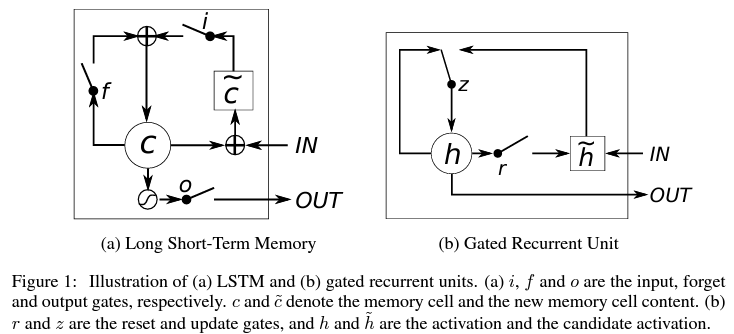 \\

After going through the data, the model produces the last hidden state vector. We are going to use an additional linear transformation layer to map this vector to the final output, whose size is same as the number of classes.

In [ ]:
# The GRU Classifier class.
class GRUClassifier(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(GRUClassifier, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.GRU(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=0.2,
        batch_first=True
    )
    self.linear = nn.Linear(hidden_size, num_classes)

  def forward(self, x):  # (B, T, D)
    h_0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)).to(x.device)  # (L, B, H)
    x, h_n = self.rnn(x, h_0)  # (B, T, H), (L, B, H)
    return self.linear(torch.mean(x, dim=1))  # (B, C)

In [ ]:
# Training the classifier.
fix_seed(seed)
gru_cls = GRUClassifier(len(features), 64, 2, 4).to(device)
learning_rate=1e-4
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(gru_cls.parameters(), lr=learning_rate)

fix_seed(seed)
gru_train_losses, gru_train_f1s = [], []
for e in range(num_epochs):
  loss_sum = 0.0
  y_true, y_pred = [], []
  total = 0
  for inputs, labels in tqdm(train_cls_loader):
    inputs, labels = inputs.to(device), labels.to(device)  # (B, T, D), (B)
    preds = gru_cls(inputs)  # (B, C)
    loss = criterion(preds, labels)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_sum += loss.item()
    y_pred += torch.argmax(preds, dim=-1).tolist()
    y_true += labels.tolist()
    total += inputs.shape[0]

  avg_loss = loss_sum / total
  f1 = f1_score(y_true, y_pred, average='micro')
  print(f"Epoch: {e}")
  print(f"CrossEntropy Loss: {avg_loss}")
  print(f"F1 score: {f1}")

  gru_train_losses.append(avg_loss)
  gru_train_f1s.append(f1)

In [ ]:
# Plotting the training loss and f1 scores.
epochs = list(range(num_epochs))

fig, ax = plt.subplots(1,2)
fig.suptitle("The train results: GRU Classifier")
train_ax = sns.lineplot(x=epochs, y=gru_train_losses, ax=ax[0])
test_ax = sns.lineplot(x=epochs, y=gru_train_f1s, ax=ax[1])

train_ax.set_title('The train loss per epoch')
train_ax.set(xlabel='Epoch', ylabel='Train loss')

test_ax.set_title('The f1 score per epoch')
test_ax.set(xlabel='Epoch', ylabel='F1 score')

In [ ]:
# Testing on the test set.
loss_sum = 0.0
y_true, y_pred = [], []
total = 0
gru_cls.eval()
with torch.no_grad():
  for inputs, labels in test_cls_loader:
    inputs, labels = inputs.to(device), labels.to(device)  # (B, T, D), (B)
    preds = gru_cls(inputs)  # (B, C)
    loss = criterion(preds, labels)

    loss_sum += loss.item()
    y_pred += torch.argmax(preds, dim=-1).tolist()
    y_true += labels.tolist()
    total += inputs.shape[0]

gru_test_loss = loss_sum / total
gru_test_f1 = f1_score(y_true, y_pred, average='micro')
print(f"CrossEntropy Loss: {gru_test_loss}")
print(f"F1 score: {gru_test_f1}")

## Classification - TransformerEncoder Classifier

Lastly, we are going to test one of the most popular models in recent deep learning research, the Transformer. Transformer is originally an encoder-decoder generation model for machine translation, which is one of the research fields in natural language processing, suggested in the publication called "Attention is all you need"(https://arxiv.org/pdf/1706.03762). It improved language understanding & generation capability without recurrent time series modeling, but only with attention mechanism which models how much each feature of an input should focus on others. This enables the model to focus on the features which are far from the current feature and to process generation faster with parallelism. \\
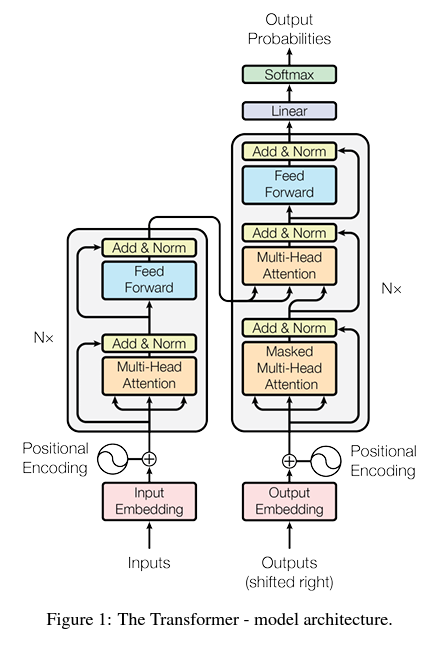 \\

Since what we are going to do is classification, we don't need the decoder part, which is mainly for generation of outputs. Thus, only the encoder will be used to bidirectionally process the time series data. Unlike GRU, the transformer encoder produces the outputs containing the hidden state vectors from all time steps. In order to aggregate these and make them into one vector for classification, we will use the mean pooling, averaging all features from different time stps, and then linearly project pooled vector into the final output.

In [ ]:
# The Transformer Classifier class.
class TransformerClassifier(nn.Module):
  def __init__(self, input_size, hidden_size, intermediate_size, num_heads, num_layers, num_classes):
    super(TransformerClassifier, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.encoder = nn.TransformerEncoder(
        encoder_layer = nn.TransformerEncoderLayer(
          d_model=hidden_size, 
          nhead=num_heads,
          dim_feedforward=intermediate_size,
          dropout=0.2,
        ),
        num_layers=num_layers
    )
    self.linear2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):  # (B, T, D)
    x = self.linear1(x)  # (B, T, H)
    x = self.encoder(x.transpose(0, 1))  # (T, B, H)
    x = x.transpose(0, 1)  # (B, T, H)
    return self.linear2(torch.mean(x, dim=1))  # (B, C)

In [ ]:
# Training the classifier.
fix_seed(seed)
trans_cls = TransformerClassifier(len(features), 64, 256, 4, 2, 4).to(device)
learning_rate=1e-4
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(trans_cls.parameters(), lr=learning_rate)

fix_seed(seed)
trans_train_losses, trans_train_f1s = [], []
for e in range(num_epochs):
  loss_sum = 0.0
  y_true, y_pred = [], []
  total = 0
  for inputs, labels in tqdm(train_cls_loader):
    inputs, labels = inputs.to(device), labels.to(device)  # (B, T, D), (B)
    preds = trans_cls(inputs)  # (B, C)
    loss = criterion(preds, labels)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_sum += loss.item()
    y_pred += torch.argmax(preds, dim=-1).tolist()
    y_true += labels.tolist()
    total += inputs.shape[0]

  avg_loss = loss_sum / total
  f1 = f1_score(y_true, y_pred, average='micro')
  print(f"Epoch: {e}")
  print(f"CrossEntropy Loss: {avg_loss}")
  print(f"F1 score: {f1}")

  trans_train_losses.append(avg_loss)
  trans_train_f1s.append(f1)

In [ ]:
# Plotting the training loss and f1 scores.
epochs = list(range(num_epochs))

fig, ax = plt.subplots(1,2)
fig.suptitle("The train results: Transformer Classifier")
train_ax = sns.lineplot(x=epochs, y=trans_train_losses, ax=ax[0])
test_ax = sns.lineplot(x=epochs, y=trans_train_f1s, ax=ax[1])

train_ax.set_title('The train loss per epoch')
train_ax.set(xlabel='Epoch', ylabel='Train loss')

test_ax.set_title('The f1 score per epoch')
test_ax.set(xlabel='Epoch', ylabel='F1 score')

In [ ]:
# Testing on the test set.
loss_sum = 0.0
y_true, y_pred = [], []
total = 0
trans_cls.eval()
with torch.no_grad():
  for inputs, labels in test_cls_loader:
    inputs, labels = inputs.to(device), labels.to(device)  # (B, T, D), (B)
    preds = trans_cls(inputs)  # (B, C)
    loss = criterion(preds, labels)

    loss_sum += loss.item()
    y_pred += torch.argmax(preds, dim=-1).tolist()
    y_true += labels.tolist()
    total += inputs.shape[0]

trans_test_loss = loss_sum / total
trans_test_f1 = f1_score(y_true, y_pred, average='micro')
print(f"CrossEntropy Loss: {trans_test_loss}")
print(f"F1 score: {trans_test_f1}")

## Classification - Comparison & Analysis on the results

In [ ]:
# Plotting the test f1 scores from each model.
sns.set(rc={'figure.figsize': (12, 8)}, font_scale=1.5)
ax = sns.barplot(x=['Feed-Forward', 'GRU', 'Transformer'], y=[ff_test_f1, gru_test_f1, trans_test_f1])
ax.set_title("The test F1 score per model")
for p in ax.patches:
  ax.annotate(round(p.get_height(), 4), xy=(p.get_x() + p.get_width() / 3, p.get_height() * 1.01))

As mentioned above, the overall performances from the trained models might not be satisfactory. We concluded that the models were severly underfit, because as we can see from the curves of training errors, the value was not reduced significantly from some point, so it seemed that the weights converged. We could see that estimating stock price change is a hard task, since there are a lot of factors interwined. In conclusion, the features we selected were not sufficient to make meaningful results.

We should discuss additionally why each model has slightly different perforamcne on the test set. Although the differences are not significant, overall it seems that the feed-forward network is weak to catch the time-series data's patterns than GRU and Transformer, since other two models were designed for processing sequential data originally. The feed-forward network treats the features from different time step almost identically to other features in the same time step with fully-connected layer, it would be less competent to catch the temporal characteristics. \\
In addition, the performance between GRU and Transformer is almost identical. This means that the property of the transformer could not make a significant difference. We think that the bidirectional attention mechanim of transformer did not help to improve the performance, which means that it is not needed for predicting the movement of stock price which is uni-directional and hightly sequential, unlike the human language.

## Comments on Our Data and Models

### 1. Survivorship Bias

![alt text](https://static.seekingalpha.com/uploads/2015/9/28/865411-14434768932109504-Boris-Marjanovic.png)

In analyzing stock price data, one of the caveats is the survivorship bias. It means that if you predict the future stock price based on the historical data of current top N companies, it implicitly assumes that you have the ability to know which firms are not going to be bankrupt by that year. However, in our dataset, the top 2,000 public companies changes periodically based on their market capitalizations hence there is less concern about this bias.

### 2. Train-Test Split

![alt text](https://www.ft.com/__origami/service/image/v2/images/raw/https%3A%2F%2Fd1e00ek4ebabms.cloudfront.net%2Fproduction%2F5d22901f-a941-4f19-8569-515ddf036748.jpg?dpr=1&fit=scale-down&source=next&width=700)

If there are significant differences in the characteristics of the market between the train dataset (in our case, stock prices data in 2017-2020) and the test dataset (in our case, stock prices data in 2021) due to (for example) the change of market regime according to COVID-19, it is unreasonable to split train and test data in this way. However, being different from most other countries, the Bank of Japan (BOJ) has conducted quantitative easing (QE) for more than 10 years which is known for Abenomics (i.e., BOJ had still conducted QE in 2020-2021 to resolve chronic deflation in its economy rather than dealing with COVID-19), so it is hard to say that there is the significant change of market regime after COVID-19 in the Japanese stock market.

One might say that what if splitting train and test dataset every other year (e.g., set stock price data in 2017, 2019, and 2021 as the train dataset and stock price data in 2018 and 2020 as the test dataset)? But in this case, there is an obvious problem of look-ahead bias as in this way train data will include the information of the test data, hence the test dataset becomes contaminated (for a simplified example, if we decide to invest in a stock in March, we can only use the data before March).

### 3. Consideration on Features

![alt text](https://i0.wp.com/scienceagri.com/wp-content/uploads/2022/01/investor-gurus-1.jpg?ssl=1)

In this project, we decided to focus on short-term investment rather than long-term investment based on the quantitative indicators. We chose this approach because it is hard to gain the feature data needed to conduct fundamental analysis for long-term investment. For example, the data needed for fundamental analysis such as Real GDP, company filings (e.g., 10-K and 10-Q), and labor statistics are published quarterly, half-yearly, or yearly, hence it is hard to use these kinds of data as the features in machine learning for stock price prediction*. In addtion, alternative data for fundamental analysis such as satellite pictures (to check real time floating population in retail places) is very expensive to get and is usually used by institutional investors. These constraints limited our features selection thus we focused on quantitative indicators.

*This is the reason most of the gurus in the Wall Street such as Howard Marks, Ron Baron, and Warren Buffett (though some of them do not actually stay in the Wall Street) are long-term investors, while most of the short-term investments such as high-frequency trading (HFT), day trading, and swing trading have been replaced with algorithm trading systems. 